In [10]:
import importlib
import numpy as np
import torchviz
import wandb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import io
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import util
from util import TokenMergeBuffer, TokenUnmergeBuffer
from toy_data.data import CircleND, Circle2D
from models import AE

from types import SimpleNamespace

## Dataset

In [2]:
class CircleTokenDataset(torch.utils.data.Dataset):
    def __init__(self, N=1000, m=16):
        self.N = N
        self.m = m
        circle = Circle2D(n=N).generate().add_noise()
        self.points = torch.tensor(circle.data, dtype=torch.float32)  # [N,2]

    def __len__(self):
        return 10_000  # arbitrary number of samples

    def __getitem__(self, idx):
        # pick m unique points each time
        ids = torch.randperm(self.N)[:self.m]
        return self.points[ids]     # [m,2]


In [3]:
dataset = CircleTokenDataset(N=1000, m=16)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [4]:
b = next(iter(train_loader))
b.shape

torch.Size([64, 16, 2])

## Training

### Eval

In [31]:
@torch.no_grad()
def evaluate(model, val_loader, device, policy="softmax", max_depth=None):
    """
    Full validation pass for the merging Autoencoder.

    Args:
        model: AE model with lift/encode/decode.
        val_loader: DataLoader
        device: torch.device
        policy: merging policy ("argmin", "uniform", "softmax")
    """
    model.eval()
    total_val_loss = 0.0

    for batch in val_loader:
        raw_tokens = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)

        # === LIFT TOKENS ===
        lifted = model.lift(raw_tokens)
        buf = TokenMergeBuffer(lifted)

        # === MERGE LOOP ===
        while buf.n_active_tokens > 1 and (max_depth is None or buf.n_merge < max_depth):
            active = buf.get_active_tokens()
            B, N, D = active.shape
            pair_idx = torch.combinations(torch.arange(N, device=device))
            num_pairs = pair_idx.shape[0]

            t1 = active[:, pair_idx[:, 0], :]
            t2 = active[:, pair_idx[:, 1], :]
            x = torch.cat([t1, t2], dim=-1)
            x_flat = x.reshape(B * num_pairs, -1)

            x_hat = model(x_flat)
            recon_loss = (x_hat - x_flat).pow(2).mean(dim=1)
            loss_per_pair = recon_loss.view(B, num_pairs)

            # Deterministic policy by default (for stable validation)
            if policy == "argmin":
                chosen = loss_per_pair.argmin(dim=1)
            elif policy == "softmax":
                probs = torch.softmax(-loss_per_pair, dim=1)
                chosen = torch.multinomial(probs, 1).squeeze(1)
            elif policy == "uniform":
                chosen = torch.randint(0, num_pairs, (B,), device=device)
            else:
                raise ValueError(f"Unknown policy {policy}")

            local_t1_idx = pair_idx[chosen, 0]
            local_t2_idx = pair_idx[chosen, 1]

            chosen_t1 = active[torch.arange(B), local_t1_idx, :]
            chosen_t2 = active[torch.arange(B), local_t2_idx, :]
            chosen_x = torch.cat([chosen_t1, chosen_t2], dim=-1)

            merged_tokens = model.encode(chosen_x)
            buf.merge_batch(local_t1_idx, local_t2_idx, merged_tokens)

        # === UNMERGE LOOP ===
        buffer = buf.buffer
        merge_history = buf.get_merge_history()
        active_mask = buf.get_active_mask()
        n_original_tokens = raw_tokens.shape[1]

        unmerge_buf = TokenUnmergeBuffer(buffer=buffer,
                                            active_mask=active_mask,
                                            merges=merge_history,
                                            n_original=n_original_tokens)

        while not unmerge_buf.is_done():
            merged_token = unmerge_buf.get_next_to_unmerge()
            pred = model.decode(merged_token)
            t1_pred, t2_pred = torch.chunk(pred, 2, dim=-1)
            unmerge_buf.step_unmerge(t1_pred, t2_pred)

        reconstructed = unmerge_buf.get_original_tokens()
        reconstructed_unlifted = model.unlift(reconstructed)

        loss = (reconstructed_unlifted - raw_tokens).pow(2).mean()
        total_val_loss += loss.item()

    return total_val_loss / len(val_loader)


### Visualisation

In [30]:
@torch.no_grad()
def visualise_reconstruction(model, val_loader, config, device, max_depth=None, log_wandb=False):

    raw_tokens = next(iter(val_loader))

    lifted = model.lift(raw_tokens)
    buf = TokenMergeBuffer(lifted)

    while buf.n_active_tokens > 1 and (max_depth is None or buf.n_merge < max_depth):
        active = buf.get_active_tokens()  # (B, N, D)
        B, N, D = active.shape

        pair_idx = torch.combinations(torch.arange(N, device=device))
        num_pairs = pair_idx.shape[0]

        t1 = active[:, pair_idx[:, 0], :]
        t2 = active[:, pair_idx[:, 1], :]
        x = torch.cat([t1, t2], dim=-1)
        x_flat = x.reshape(B * num_pairs, -1)

        x_hat = model(x_flat)
        recon_loss = (x_hat - x_flat).pow(2).mean(dim=1)
        loss_per_pair = recon_loss.view(B, num_pairs)

        # === SELECTION POLICY ===
        policy = config.sampling_policy
        if policy == "argmin":
            chosen = loss_per_pair.argmin(dim=1)
        elif policy == "uniform":
            chosen = torch.randint(0, num_pairs, (B,), device=device)
        elif policy == "softmax":
            probs = torch.softmax(-loss_per_pair, dim=1)
            chosen = torch.multinomial(probs, 1).squeeze(1)
        else:
            raise ValueError(f"Unknown sampling policy: {policy}")

        local_t1_idx = pair_idx[chosen, 0]
        local_t2_idx = pair_idx[chosen, 1]

        chosen_t1 = active[torch.arange(B), local_t1_idx, :]
        chosen_t2 = active[torch.arange(B), local_t2_idx, :]
        chosen_x = torch.cat([chosen_t1, chosen_t2], dim=-1)

        merged_tokens = model.encode(chosen_x)
        buf.merge_batch(local_t1_idx, local_t2_idx, merged_tokens)

    # === UNMERGE LOOP ===
    buffer = buf.buffer
    merge_history = buf.get_merge_history()
    active_mask = buf.get_active_mask()
    n_original_tokens = raw_tokens.shape[1]

    unmerge_buf = TokenUnmergeBuffer(buffer=buffer,
                                    active_mask=active_mask,
                                    merges=merge_history,
                                    n_original=n_original_tokens)

    while not unmerge_buf.is_done():
        merged_token = unmerge_buf.get_next_to_unmerge()
        pred = model.decode(merged_token)
        t1_pred, t2_pred = torch.chunk(pred, 2, dim=-1)
        unmerge_buf.step_unmerge(t1_pred, t2_pred)

    reconstructed = unmerge_buf.get_original_tokens()
    reconstructed_unlifted = model.unlift(reconstructed)

    # complete_recon_loss = (reconstructed - lifted).pow(2).mean()

    # print(f"reconstructed_unlifted.shape: {reconstructed_unlifted.shape}")

    all_x1, all_y1 = [], []
    all_x2, all_y2 = [], []

    for i in range(len(raw_tokens)): # loop over multiple samples
        x = raw_tokens[i]
        x_hat = reconstructed_unlifted[i]

        all_x1.append(x[:, 0].cpu().numpy())
        all_y1.append(x[:, 1].cpu().numpy())
        all_x2.append(x_hat[:, 0].cpu().numpy())
        all_y2.append(x_hat[:, 1].cpu().numpy())

    # concatenate everything
    x1 = np.concatenate(all_x1)
    y1 = np.concatenate(all_y1)
    x2 = np.concatenate(all_x2)
    y2 = np.concatenate(all_y2)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(x1, y1, c='blue', s=40, label='Original')
    ax.scatter(x2, y2, c='red', s=40, label='Reconstructed')
    ax.set_title('Circle2D Sample Tokens')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(-1.25, 1.25)
    ax.set_ylim(-1.25, 1.25)
    ax.set_aspect('equal') 
    ax.legend()

    if log_wandb:
        wandb.log({"reconstruction_plot": wandb.Image(fig)})
    else:
        plt.show()
    plt.close(fig)

In [7]:
@torch.no_grad()
def visualize_latents(model, val_loader, device, log_wandb=False, max_batches=4):
    """
    Collects latent vectors produced by model.encode during merging and
    visualizes:
       - mean/variance per latent dimension
       - histogram per dimension
       - PCA of embeddings
    """

    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    latents = []

    # ---- COLLECT LATENTS OVER MULTIPLE BATCHES ----
    for batch_idx, raw_tokens in enumerate(val_loader):

        if batch_idx >= max_batches:
            break

        lifted = model.lift(raw_tokens)
        buf = TokenMergeBuffer(lifted)

        while buf.n_active_tokens > 1:
            active = buf.get_active_tokens()   # (B, N, D)
            B, N, D = active.shape
            pair_idx = torch.combinations(torch.arange(N, device=device))
            num_pairs = pair_idx.shape[0]

            # build all pairs
            t1 = active[:, pair_idx[:, 0], :]
            t2 = active[:, pair_idx[:, 1], :]
            x_flat = torch.cat([t1, t2], dim=-1).reshape(B * num_pairs, -1)

            # encode the "chosen" pair deterministically
            # (choose lowest recon error, because your code does that)
            x_hat = model(x_flat)
            recon_loss = (x_hat - x_flat).pow(2).mean(dim=1)
            loss_per_pair = recon_loss.view(B, num_pairs)
            chosen = loss_per_pair.argmin(dim=1)

            l1_idx = pair_idx[chosen, 0]
            l2_idx = pair_idx[chosen, 1]

            chosen_t1 = active[torch.arange(B), l1_idx, :]
            chosen_t2 = active[torch.arange(B), l2_idx, :]
            chosen_x = torch.cat([chosen_t1, chosen_t2], dim=-1)

            z = model.encode(chosen_x)        # <---- LATENT VECTOR
            latents.append(z.cpu().numpy())

            buf.merge_batch(l1_idx, l2_idx, z)

    # ---- STACK ALL LATENTS (num_merges, B, latent_dim) ----
    Z = np.concatenate(latents, axis=0)
    print(f"[latent visualize] collected Z.shape = {Z.shape}")

    # ---- STATS PER DIM ----
    mean = Z.mean(axis=0)
    var = Z.var(axis=0)

    fig1, ax1 = plt.subplots(figsize=(6,3))
    ax1.plot(mean, label="mean per dim")
    ax1.plot(var, label="var per dim")
    ax1.legend()
    ax1.set_title("Latent Dimension Usage (mean/var)")
    if log_wandb:
        wandb.log({"latent_meanvar": wandb.Image(fig1)})
    else:
        plt.show()
    plt.close(fig1)

    # ---- PCA ----
    pca = PCA(n_components=2)
    Z2 = pca.fit_transform(Z)

    fig2, ax2 = plt.subplots(figsize=(5,5))
    ax2.scatter(Z2[:,0], Z2[:,1], s=6)
    ax2.set_title("PCA of latent vectors")
    if log_wandb:
        wandb.log({"latent_pca": wandb.Image(fig2)})
    else:
        plt.show()
    plt.close(fig2)

    # ---- HISTOGRAMS ----
    fig3, ax3 = plt.subplots(figsize=(10,4))
    ax3.hist(Z.flatten(), bins=80, alpha=0.8)
    ax3.set_title("Histogram of all latent values")
    if log_wandb:
        wandb.log({"latent_hist": wandb.Image(fig3)})
    else:
        plt.show()
    plt.close(fig3)

    return Z, mean, var


### Train

In [27]:
def get_merge_depth(curr_epoch, total_epochs, max_depth):
    progress = curr_epoch / total_epochs
    return int(progress * max_depth)

In [ ]:
def train(
        model, 
        train_loader,
        val_loader,
        config,
        device,
        checkpoint_path=None,
        max_depth=None,
        ):
    
    model.to(device)
    optimiser = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    best_val_loss = float('inf')

    wandb.init(
        project="merging-AE",
        config=config,
        name=config.model_name
    )

    for epoch in range(config.epochs):
        model.train()
        total_train_loss = 0.0

        for batch in train_loader:
            optimiser.zero_grad()

            raw_tokens = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)

            # === LIFT TOKENS ===
            lifted = model.lift(raw_tokens)
            buf = TokenMergeBuffer(lifted)

            current_depth = get_merge_depth(epoch+1, config.epochs, config.max_depth)

            # # === MERGE LOOP ===
            # while buf.n_active_tokens > 1 and (max_depth is None or buf.n_merge < max_depth):
            while buf.n_active_tokens > 1 and buf.n_merge < current_depth:

                active = buf.get_active_tokens()  # (B, N, D)
                B, N, D = active.shape

                pair_idx = torch.combinations(torch.arange(N, device=device))
                num_pairs = pair_idx.shape[0]

                t1 = active[:, pair_idx[:, 0], :]
                t2 = active[:, pair_idx[:, 1], :]
                x = torch.cat([t1, t2], dim=-1)
                x_flat = x.reshape(B * num_pairs, -1)

                with torch.no_grad():
                    x_hat = model(x_flat)
                    recon_loss = (x_hat - x_flat).pow(2).mean(dim=1)
                    loss_per_pair = recon_loss.view(B, num_pairs)

                # === SELECTION POLICY ===
                policy = config.sampling_policy
                if policy == "argmin":
                    chosen = loss_per_pair.argmin(dim=1)
                elif policy == "uniform":
                    chosen = torch.randint(0, num_pairs, (B,), device=device)
                elif policy == "softmax":
                    probs = torch.softmax(-loss_per_pair, dim=1)
                    chosen = torch.multinomial(probs, 1).squeeze(1)
                else:
                    raise ValueError(f"Unknown sampling policy: {policy}")

                local_t1_idx = pair_idx[chosen, 0]
                local_t2_idx = pair_idx[chosen, 1]

                chosen_t1 = active[torch.arange(B), local_t1_idx, :]
                chosen_t2 = active[torch.arange(B), local_t2_idx, :]
                chosen_x = torch.cat([chosen_t1, chosen_t2], dim=-1)

                merged_tokens = model.encode(chosen_x)
                buf.merge_batch(local_t1_idx, local_t2_idx, merged_tokens)
            

            # === UNMERGE LOOP ===
            buffer = buf.buffer
            merge_history = buf.get_merge_history()
            active_mask = buf.get_active_mask()
            n_original_tokens = raw_tokens.shape[1]

            unmerge_buf = TokenUnmergeBuffer(buffer=buffer,
                                             active_mask=active_mask,
                                             merges=merge_history,
                                             n_original=n_original_tokens)

            while not unmerge_buf.is_done():
                merged_token = unmerge_buf.get_next_to_unmerge()
                pred = model.decode(merged_token)
                t1_pred, t2_pred = torch.chunk(pred, 2, dim=-1)
                unmerge_buf.step_unmerge(t1_pred, t2_pred)

            reconstructed = unmerge_buf.get_original_tokens()
            reconstructed_unlifted = model.unlift(reconstructed)

            complete_recon_loss = (reconstructed_unlifted - raw_tokens).pow(2).mean()

            # if epoch == 0 and total_train_loss == 0:  # only on first batch
            #     dot = torchviz.make_dot(complete_recon_loss,
            #                 params=dict(model.named_parameters()))
            #     dot.format = "png"
            #     dot.render("graph")   # Produces graph.png

            complete_recon_loss.backward()
            optimiser.step()

            total_train_loss += complete_recon_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # === VALIDATION ===
        val_loss = evaluate(model, val_loader, device, config.sampling_policy, max_depth)

        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "epoch": epoch,
            "merge_depth": current_depth,
            })


        # === SAVE BEST ===
        if checkpoint_path and val_loss < best_val_loss:
            best_val_loss = val_loss
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save(model.state_dict(), checkpoint_path)

            visualise_reconstruction(model, val_loader, config, device, max_depth=max_depth, log_wandb=True)
        

    wandb.finish()

### Main

In [33]:
token_dim = 2
latent_dim = 4
hidden_dim = 64
max_depth = 8

config = SimpleNamespace(
    epochs=50,
    learning_rate=1e-3,
    sampling_policy="softmax",
    batch_size=64,
    device=device,
    model_name=f"AE-softmax-circle-lr-{1e-3}-latent-{latent_dim}-max-depth-{max_depth}-curriculum-depth",
    max_depth=max_depth,
    latent_dim=latent_dim,
    token_dim=token_dim,
    hidden_dim=hidden_dim,
)

model = AE(
    token_dim=token_dim,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim
    ).to(device)

train(model, train_loader, val_loader, config, device, checkpoint_path=f"./checkpoints/{config.model_name}.pth", max_depth=max_depth)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
merge_depth,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▃▄▄▅▅▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,49
merge_depth,7
train_loss,0.09068
val_loss,0.11024


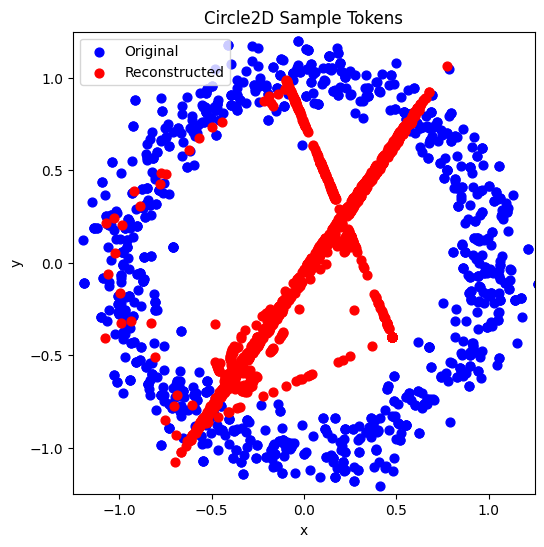

In [ ]:
visualise_reconstruction(model, val_loader, config, device, max_depth=max_depth)

TODO:
- viz der einzelnen latent dims
- 